In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, f1_score, accuracy_score, precision_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA, IncrementalPCA, LatentDirichletAllocation
from sklearn.manifold import TSNE

from tqdm.notebook import tqdm, trange
from typing import NoReturn, Union, List
from mlxtend.classifier import EnsembleVoteClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from umap import UMAP


2022-04-29 09:05:56.562479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-29 09:05:56.562514: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
dev = False

In [4]:
# time and amount scaling
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

df_anom = df[df['Class'] == 1]
df_norm = df[df['Class'] == 0]

if dev:
    df_norm = df_norm.sample(5000, random_state=42)
df_test_norm = df_norm.sample(df_anom.shape[0])
df_test = pd.concat([
    df_anom,
    df_test_norm
])
df_train = df_norm.drop(df_test_norm.index)

feature_cols = [_ for _ in df.columns if _ != 'Class']

In [5]:
X_train = df_train[feature_cols]
y_train = df_train['Class'] # will not be used
X_test = df_test[feature_cols]
y_test = df_test['Class'] # for evaluation
print('''
train: [{:>8} x {:<5}]
 test: [{:>8} x {:<5}]
'''.format(*X_train.shape, *X_test.shape))


train: [  283823 x 30   ]
 test: [     984 x 30   ]



In [6]:
def sensitivity_keras(y_true, y_pred):
    """credits: https://datascience.stackexchange.com/a/40746/28592
    
    param:
    y_pred - Predicted labels
    y_true - True labels 
    Returns:
    Specificity score
    """
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = tf.keras.backend.sum(neg_y_true * y_pred)
    tn = tf.keras.backend.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + tf.keras.backend.epsilon())
    return specificity

In [7]:
class Scaled_IsolationForest(IsolationForest):
    """The purpose of this sub-class is to transform prediction values from {-1, 1} to {1,0}
    """
    def predict(self, X):
        pred = super().predict(X)
        scale_func = np.vectorize(lambda x: 1 if x == -1 else 0)
        return scale_func(pred)

class Scaled_OneClass_SVM(OneClassSVM):
    """The purpose of this sub-class is to transform prediction values from {-1, 1} to {1,0}
    """
    def predict(self, X):
        return np.array([y==-1 for y in super().predict(X)])
    
class NoveltyDetection_Sequential(tf.keras.models.Sequential):
    """This custom `tf.keras.models.Sequential` sub-class transforms autoencoder's output into {1,0}.
    Output value is determined based on reproduction (decode) loss. If reproduction loss is more than a threashold then, the input sample is considered as anomaly (outlier).
    Based on few experiments, 1.5 is a dissent threashold (don't as why :P). Future work: determine the threashold using a more sophisticated method.
    """
    def predict(self, x, *args, **kwargs):
        pred = super().predict(x, *args, **kwargs)
        mse = np.mean(np.power(x - pred, 2), axis=1)
        scale_func = np.vectorize(lambda x: 1 if x > 1.5 else 0)
        return scale_func(mse)

In [8]:
# define early stop in order to prevent overfitting and useless training
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='mse',
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True,
)

# it's a common practice to store the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoenc.hdf5',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=0
)

def get_autoencoder() -> tf.keras.models.Sequential:
    """Build an autoencoder
    """
    model = NoveltyDetection_Sequential([
        tf.keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1], )),
        # add some noise to prevent overfitting
        tf.keras.layers.GaussianNoise(0.05),
        tf.keras.layers.Dense(2, activation='relu'),
        tf.keras.layers.Dense(X_train.shape[1], activation='relu')
    ])
    model.compile(optimizer='adam', 
                        loss='mse',
                        metrics=['acc', sensitivity_keras])
    return model

In [9]:
clfs = {
    'isolation_forest': {
        'label': 'Isolation Forest',
        'clb': Scaled_IsolationForest,
        'params': {
            'contamination': 'auto',
            'n_estimators': 300
        },
        'predictions': None,
        'model': None
    },
    'ocsvm': {
        'label': 'OneClass SVM',
        'clb': Scaled_OneClass_SVM,
        'params': {
            'kernel': 'rbf',
            'gamma': 0.3,
            'nu': 0.01,
        },
        'prediction': None,
        'model': None
    },
    'auto-encoder': {
        'label': 'Autoncoder',
        'clb': get_autoencoder,
        'params': {},
        'fit_params': {
            'x': X_train, 'y': X_train,
            'validation_split': 0.2,
            'callbacks': [early_stop, checkpoint],
            'epochs': 64,
            'batch_size': 256,
            'verbose': 0
        },
        'predictions': None,
        'model': None
    }
}

In [10]:
%%time

t = trange(len(clfs))
for name in clfs:
    t.set_description(clfs[name]['label'])
    clfs[name]['model'] = clfs[name]['clb'](**clfs[name]['params'])
    if 'fit_params' in clfs[name]:
        clfs[name]['model'].fit(**clfs[name].get('fit_params', {}))
    else:
        clfs[name]['model'].fit(X_train)
    clfs[name]['predictions'] = clfs[name]['model'].predict(X_test)
    t.update()
t.close()

  0%|          | 0/3 [00:00<?, ?it/s]

2022-04-29 10:53:26.576352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 10:53:26.577020: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-29 10:53:26.577293: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-29 10:53:26.577530: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-29 10:53:26.577761: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

CPU times: user 1h 48min 28s, sys: 16.2 s, total: 1h 48min 44s
Wall time: 1h 48min 20s


In [11]:
def print_eval_metrics(y_true, y_pred, name='', header=True):
    """Function for printing purposes
    """
    if header:
        print('{:>20}\t{:>10}\t{:>10}\t{:>8}\t{:>5}'.format('Algorith', 'Accuracy', 'Recall', 'Precision', 'f1'))
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print('{:>20}\t{:>1.8f}\t{:>1.8f}\t{:>1.6f}\t{:>1.3f}'.format(
        name, acc, recall, prec, f1
    ))

In [35]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Copyed from a kernel by joparga3 https://www.kaggle.com/joparga3/kernels
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [12]:
y_preds = np.column_stack([clfs[_]['predictions'] for _ in clfs])
enseble_preds = []

In [13]:
hard_vot = EnsembleVoteClassifier([clfs[_]['model'] for _ in clfs], fit_base_estimators=False)
hard_vot.fit(X_test, y_test)
enseble_preds.append((hard_vot.predict(X_test), 'Hard Voting'))

/home/victor/Victor/Work/CIC/.pyenv/lib/python3.10/site-packages/mlxtend/classifier/ensemble_vote.py:166: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn("fit_base_estimators=False "


In [14]:
wei_hard_vot = EnsembleVoteClassifier([clfs[_]['model'] for _ in clfs], weights=[
        0.4,
        0.1,
        0.8
    ], fit_base_estimators=False)
wei_hard_vot.fit(X_test, y_test)
enseble_preds.append((wei_hard_vot.predict(X_test), 'Weighted Hard Voting'))

/home/victor/Victor/Work/CIC/.pyenv/lib/python3.10/site-packages/mlxtend/classifier/ensemble_vote.py:166: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn("fit_base_estimators=False "


In [15]:
rf = RandomForestClassifier()

x_tr_ens, x_ts_ens, y_tr_ens, y_ts_ens = train_test_split(y_preds, y_test, test_size=.5)
rf.fit(x_tr_ens, y_tr_ens)

RandomForestClassifier()

In [16]:
print_header = True
for k, v in clfs.items():
    print_eval_metrics(y_test, v['predictions'], v['label'], print_header)
    print_header = False

print('\n')

for prds, l in enseble_preds:
    print_eval_metrics(y_test, prds, l, print_header)
    print_header = False

print('\n')
    
print_eval_metrics(
    y_ts_ens,
    rf.predict(x_ts_ens),
    'Bleding using RF', False
)

            Algorith	  Accuracy	    Recall	Precision	   f1
    Isolation Forest	0.90040650	0.83130081	0.964623	0.893
        OneClass SVM	0.87804878	0.93699187	0.838182	0.885
          Autoncoder	0.90955285	0.88821138	0.927813	0.908


         Hard Voting	0.91260163	0.88414634	0.937500	0.910
Weighted Hard Voting	0.90955285	0.88821138	0.927813	0.908


    Bleding using RF	0.92073171	0.88510638	0.945455	0.914


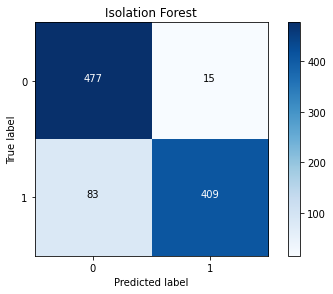

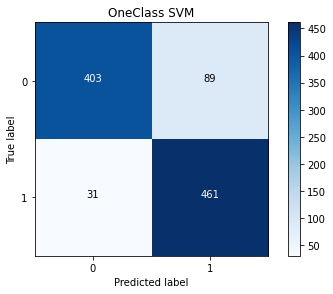

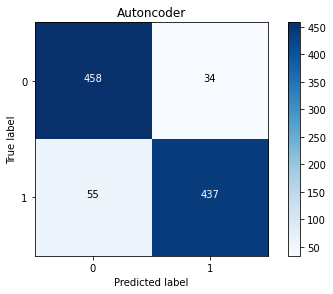

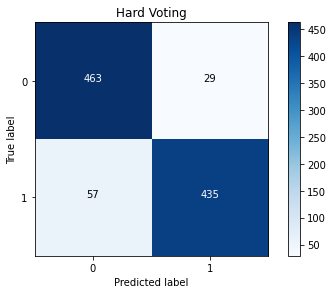

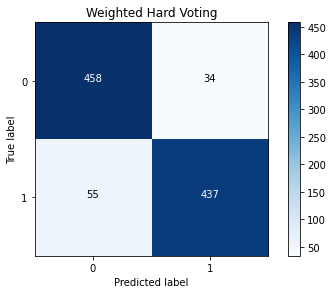

In [38]:
import itertools
for k, v in clfs.items():
    cnf = confusion_matrix(y_test, v['predictions'])
    plot_confusion_matrix(cnf,classes=["0","1"], title=v["label"])
    
for prds, l in enseble_preds:
    cnf = confusion_matrix(y_test, prds)
    plot_confusion_matrix(cnf,classes=["0","1"], title=l)

In [29]:
X_train.shape

(283823, 30)

In [26]:
X_test.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
541,-1.988034,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,-0.353229
623,-1.986644,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1.761758
4920,-1.902623,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,0.606031
6108,-1.849472,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,-0.117342
6329,-1.838248,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,-0.349231


In [28]:
y_train.value_counts()

0    283823
Name: Class, dtype: int64

In [30]:
y_test.value_counts()

1    492
0    492
Name: Class, dtype: int64

In [34]:
clfs["auto-encoder"]["predictions"].shape

(984,)